In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
SAVE_DIR = "/content/drive/MyDrive/rl_final_project/grpo/trivia"
os.makedirs(SAVE_DIR, exist_ok=True)

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

!pip install torch transformers datasets sentence-transformers faiss-cpu peft bitsandbytes -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import faiss
import copy
from typing import List
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
from sentence_transformers import SentenceTransformer

MODEL_ID = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
MAX_SEQ_LEN = 1024 
GENERATE_LEN = 64
LR = 5e-6
MAX_STEPS = 5
NUM_EPISODES = 10000
GROUP_SIZE = 4  
PRINT_EVERY = 50
SAVE_EVERY = 500
BETA_KL = 0.01  

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA L4


### CELL 2: SEARCH MODULES

*Kept exactly the same as your PPO version.*

In [4]:
import string
import re

class E5Retriever:
    def __init__(self, model_name="intfloat/e5-small-v2"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = SentenceTransformer(model_name, device=self.device)
        self.index = None
        self.docs = []

    def build_index(self, docs: List[str]):
        print(f"Building index for {len(docs)} docs...")
        self.docs = docs
        embs = self.model.encode(["passage: " + d for d in docs],
                                 normalize_embeddings=True, show_progress_bar=False)
        self.index = faiss.IndexFlatIP(embs.shape[1])
        self.index.add(embs)

    def search(self, query: str, k=1):
        q_emb = self.model.encode(["query: " + query], normalize_embeddings=True)
        D, I = self.index.search(q_emb, k)
        return [self.docs[i] for i in I[0]]

class SearchR1Environment:
    def __init__(self, retriever):
        self.retriever = retriever

    def normalize_answer(self, s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)

        def white_space_fix(text):
            return ' '.join(text.split())

        def remove_punc(text):
            exclude = set(string.punctuation)
            return ''.join(ch for ch in text if ch not in exclude)

        def lower(text):
            return text.lower()

        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def check_correctness(self, prediction, truth):
        pred_norm = self.normalize_answer(prediction)
        truth_norm = self.normalize_answer(truth)

        if pred_norm == truth_norm:
            return True

        if pred_norm in truth_norm and len(pred_norm) > 0:
            return True

        if truth_norm in pred_norm and len(truth_norm) > 0:
            return True

        return False

    def reset(self, question, answer):
        self.question = question
        self.ground_truth = answer
        self.history = []
        self.search_count = 0
        return self._format_prompt()

    def step(self, action):
        if action['type'] == 'search':
            if self.search_count >= 2: return self._format_prompt(), 0.0, False
            results = self.retriever.search(action['content'])
            context = f"\n<information>{results[0][:200]}</information>"
            self.history.append({'type': 'search', 'query': action['content'], 'result': context})
            self.search_count += 1
            return self._format_prompt(), 0.0, False

        elif action['type'] == 'answer':
            is_correct = self.check_correctness(action['content'], self.ground_truth)
            reward = 1.0 if is_correct else 0.0
            return self._format_prompt(), reward, True

        else:
            self.history.append({'type': 'think', 'content': action['content']})
            return self._format_prompt(), 0.0, False

    def _format_prompt(self):
        prompt = f"<|im_start|>user\n{self.question}\nUse <search>...</search> to search. <answer>...</answer> to finish.<|im_end|>\n<|im_start|>assistant\n"
        for h in self.history:
            if h['type'] == 'think': prompt += f"<think>{h['content']}</think>\n"
            elif h['type'] == 'search': prompt += f"<search>{h['query']}</search>\n{h['result']}\n"
        return prompt

print("Environment Ready (With Normalization)")

Environment Ready (With Normalization)


### CELL 3: MODEL SETUP

*We remove the Value Head initialization. We prepare the model to calculate reference log-probs using `disable_adapter`.*

In [5]:
print("Loading Model...")

CHECKPOINT_PATH = f"{SAVE_DIR}/final"

if os.path.exists(CHECKPOINT_PATH):
    print(f"Found checkpoint at {CHECKPOINT_PATH}, loading...")
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT_PATH)
    tokenizer.pad_token = tokenizer.eos_token
    base_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.float16, device_map="auto")
    from peft import PeftModel
    model = PeftModel.from_pretrained(base_model, CHECKPOINT_PATH)
    print("✓ Loaded from checkpoint")
else:
    print("No checkpoint found, loading fresh model...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.float16, device_map="auto")

    peft_config = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    )
    model = get_peft_model(model, peft_config)
    print("✓ Loaded fresh model")


VOCAB_SIZE = len(tokenizer)
print(f"Vocab size: {VOCAB_SIZE}")
model.print_trainable_parameters()

Loading Model...
No checkpoint found, loading fresh model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


✓ Loaded fresh model
Vocab size: 49152
trainable params: 18,087,936 || all params: 1,729,464,320 || trainable%: 1.0459


### CELL 4: GRPO POLICY NETWORK

*Changed from "SafePolicy" to "GrpoPolicy". Added `generate_group` (sampling instead of greedy) and `get_log_probs`.*

In [6]:
class GrpoPolicyNetwork(nn.Module):
    def __init__(self, model, tokenizer):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.device = next(model.parameters()).device
        self.vocab_size = len(tokenizer)

    def generate_group(self, prompt, group_size=GROUP_SIZE):
        """Generates multiple outputs for the same prompt to form a group."""
        inputs = self.tokenizer(
            [prompt] * group_size, 
            return_tensors="pt",
            truncation=True,
            max_length=MAX_SEQ_LEN,
            padding=True
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_new_tokens=GENERATE_LEN,
                do_sample=True,         
                temperature=1.0,
                top_p=0.9,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
            )

        new_tokens = outputs[:, inputs['input_ids'].shape[1]:]
        text_outputs = self.tokenizer.batch_decode(new_tokens, skip_special_tokens=True)
        return text_outputs

    def get_log_probs(self, prompt, generated_text, use_ref=False):
        """Compute log probabilities for the generated text."""
        full_text = prompt + generated_text
        inputs = self.tokenizer(
            full_text,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_SEQ_LEN
        ).to(self.device)

        input_ids = inputs['input_ids']
        prompt_len = len(self.tokenizer.encode(prompt, add_special_tokens=False))
        if self.tokenizer.bos_token_id is not None and input_ids[0][0] == self.tokenizer.bos_token_id:
             prompt_len += 1

        context = self.model.disable_adapter() if use_ref else torch.no_grad() if False else torch.enable_grad()

        with context:
            if use_ref:
                with torch.no_grad():
                    outputs = self.model(input_ids)
            else:
                outputs = self.model(input_ids)

            logits = outputs.logits[:, :-1, :] 
            labels = input_ids[:, 1:]

            log_probs = F.log_softmax(logits, dim=-1)

            token_log_probs = torch.gather(log_probs, -1, labels.unsqueeze(-1)).squeeze(-1)

            mask = torch.zeros_like(token_log_probs)
            mask[:, prompt_len-1:] = 1.0

            sequence_log_prob = (token_log_probs * mask).sum(dim=-1)

        return sequence_log_prob

policy = GrpoPolicyNetwork(model, tokenizer)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

print("GRPO Policy Ready")

GRPO Policy Ready


### CELL 5: GRPO TRAINER

*Major Logic Change: Generates groups, calculates advantage using the group mean/std, computes GRPO loss.*

In [7]:
class SearchR1GrpoTrainer:
    def __init__(self, policy, optimizer, env):
        self.policy = policy
        self.optimizer = optimizer
        self.env = env

    def parse_action(self, text):
        text_lower = text.lower()
        if "<answer>" in text_lower or "answer:" in text_lower:
            if "<answer>" in text:
                content = text.split("<answer>")[-1].split("</answer>")[0]
            else:
                content = text.split("answer:")[-1].split("\n")[0]
            return {'type': 'answer', 'content': content}
        if "<search>" in text_lower or "search:" in text_lower:
            if "<search>" in text:
                content = text.split("<search>")[-1].split("</search>")[0]
            else:
                content = text.split("search:")[-1].split("\n")[0]
            return {'type': 'search', 'content': content}
        return {'type': 'think', 'content': text[:100]}

    def train_step(self, question, answer):
        self.policy.model.train()

        initial_prompt = self.env.reset(question, answer)

        group_data = []

        generated_texts = self.policy.generate_group(initial_prompt, GROUP_SIZE)

        rewards = []

        for gen_text in generated_texts:
            action = self.parse_action(gen_text)

            reward = 0.0
            if action['type'] == 'answer':
                 if action['content'].strip().lower() in answer.lower():
                     reward = 1.0
            elif action['type'] == 'search':
                 reward = 0.1

            rewards.append(reward)
            group_data.append({
                "prompt": initial_prompt,
                "generated": gen_text,
                "reward": reward
            })

        rewards_tensor = torch.tensor(rewards, device=self.policy.device)
        mean_reward = rewards_tensor.mean()
        std_reward = rewards_tensor.std() + 1e-8
        advantages = (rewards_tensor - mean_reward) / std_reward

        self.optimizer.zero_grad()
        total_loss = 0

        for i, data in enumerate(group_data):
            prompt = data['prompt']
            gen_text = data['generated']
            adv = advantages[i]

            log_prob = self.policy.get_log_probs(prompt, gen_text, use_ref=False)

            ref_log_prob = self.policy.get_log_probs(prompt, gen_text, use_ref=True)

            pg_loss = -log_prob * adv

            kl_loss = BETA_KL * (log_prob - ref_log_prob)

            loss = pg_loss + kl_loss

            loss = loss / GROUP_SIZE
            loss.backward()
            total_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(self.policy.model.parameters(), 1.0)
        self.optimizer.step()

        return total_loss, mean_reward.item()

print("✓ GRPO Trainer Ready")

✓ GRPO Trainer Ready


In [8]:
from matplotlib import pyplot as plt

def plot_results(data, title="Results", xlabel="Episode", ylabel="Value", window=100, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 5))

    episodes = list(range(1, len(data) + 1))
    ax.plot(episodes, data, alpha=0.3, color='blue', label='Raw')

    if len(data) >= window:
        smoothed = np.convolve(data, np.ones(window)/window, mode='valid')
        ax.plot(range(window, len(data) + 1), smoothed, color='blue', linewidth=2, label=f'Smoothed (w={window})')

    cumulative_avg = np.cumsum(data) / np.arange(1, len(data) + 1)
    ax.plot(episodes, cumulative_avg, color='red', linestyle='--', linewidth=2, label='Cumulative Avg')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

    return cumulative_avg[-1] if len(data) > 0 else 0

In [9]:
def get_dataset(
    name,
    subset_size,
    ds_type
):

  if name == "gsm8k":
    if ds_type == 'train':
      train_ds = load_dataset("openai/gsm8k", "main", split="train")
      train_ds = train_ds.shuffle(seed=42).select(range(subset_size))
      questions = train_ds['question']
      answers = [a.split('####')[-1].strip() for a in train_ds['answer']]
      return questions, answers
    elif ds_type == 'test':
      test_ds = load_dataset("openai/gsm8k", "main", split="test")
      test_ds = test_ds.shuffle(seed=42).select(range(subset_size))
      questions = test_ds['question']
      answers = [a.split('####')[-1].strip() for a in test_ds['answer']]
      return questions, answers

  if name == "trivia_qa":
    if ds_type == 'train':
      train_ds = load_dataset("mandarjoshi/trivia_qa", "rc", split="train")
      train_ds = train_ds.shuffle(seed=42).select(range(subset_size))
      questions = train_ds['question']
      answers = [a['value'] for a in train_ds['answer']]
      return questions, answers
    elif ds_type == 'test':
      test_ds = load_dataset("mandarjoshi/trivia_qa", "rc", split="test")
      test_ds = test_ds.shuffle(seed=42).select(range(subset_size))
      questions = test_ds['question']
      answers = [a['value'] for a in test_ds['answer']]
      return questions, answers



def get_dataset_split():
    print("Loading TriviaQA dataset...")

    ds = load_dataset("mandarjoshi/trivia_qa", "rc", split="train")

    ds = ds.shuffle(seed=42)
    subset_size = 10000
    ds = ds.select(range(subset_size))

    questions = ds['question']
    answers = [a['value'] for a in ds['answer']]

    split_idx = int(0.8 * len(questions))

    train_questions = questions[:split_idx]
    train_answers = answers[:split_idx]

    test_questions = questions[split_idx:]
    test_answers = answers[split_idx:]

    print(f"Dataset loaded and split:")
    print(f"  - Total: {len(questions)}")
    print(f"  - Train: {len(train_questions)} (80%)")
    print(f"  - Test:  {len(test_questions)} (20%)")

    return (train_questions, train_answers), (test_questions, test_answers)

In [10]:
(questions, answers), (test_questions, test_answers) = get_dataset_split()

retriever = E5Retriever()
retriever.build_index([f"Q: {q}\nA: {a}" for q, a in zip(questions, answers)])

Loading TriviaQA dataset...


Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

Dataset loaded and split:
  - Total: 10000
  - Train: 8000 (80%)
  - Test:  2000 (20%)
Building index for 8000 docs...


### CELL 6: TRAINING LOOP

*Updated to use the GRPO trainer.*


GRPO TRAINING
Episode 50/10000 | Loss: -0.1339 | Avg Group Reward: 0.0510
Episode 100/10000 | Loss: -0.4662 | Avg Group Reward: 0.0660
Episode 150/10000 | Loss: -0.8386 | Avg Group Reward: 0.0960
Episode 200/10000 | Loss: -0.6824 | Avg Group Reward: 0.1200
Episode 250/10000 | Loss: -0.0691 | Avg Group Reward: 0.1805
Episode 300/10000 | Loss: -0.2598 | Avg Group Reward: 0.1610
Episode 350/10000 | Loss: -0.5838 | Avg Group Reward: 0.0855
Episode 400/10000 | Loss: -0.1037 | Avg Group Reward: 0.1075
Episode 450/10000 | Loss: -0.5449 | Avg Group Reward: 0.1175
Episode 500/10000 | Loss: -0.4123 | Avg Group Reward: 0.1950
Saved: /content/drive/MyDrive/rl_final_project/grpo/trivia/episode_500
Episode 550/10000 | Loss: -0.0091 | Avg Group Reward: 0.1150
Episode 600/10000 | Loss: 0.0624 | Avg Group Reward: 0.0665
Episode 650/10000 | Loss: -0.2548 | Avg Group Reward: 0.0855
Episode 700/10000 | Loss: -0.1083 | Avg Group Reward: 0.1250
Episode 750/10000 | Loss: -0.0154 | Avg Group Reward: 0.0850
E

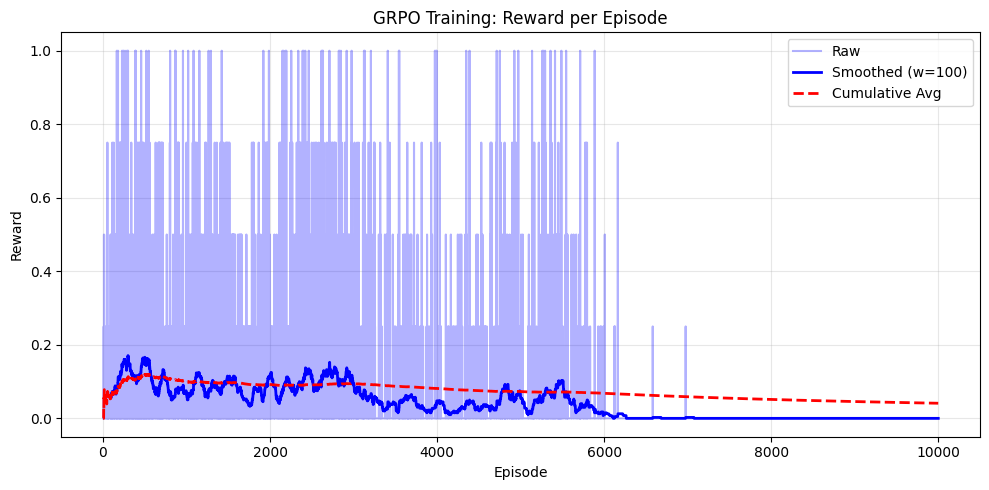

np.float64(0.04107749999221414)

In [11]:
print("\n" + "="*50)
print("GRPO TRAINING")
print("="*50)

env = SearchR1Environment(retriever)
trainer = SearchR1GrpoTrainer(policy, optimizer, env)

train_losses = []
train_rewards = []
indices = list(range(len(questions)))
np.random.shuffle(indices)

for episode in range(NUM_EPISODES):
    if episode % len(questions) == 0:
        np.random.shuffle(indices)
    idx = indices[episode % len(questions)]

    loss, reward = trainer.train_step(questions[idx], answers[idx])
    train_losses.append(loss)
    train_rewards.append(reward)

    if (episode + 1) % PRINT_EVERY == 0:
        avg_loss = sum(train_losses[-PRINT_EVERY:]) / PRINT_EVERY
        avg_reward = sum(train_rewards[-PRINT_EVERY:]) / PRINT_EVERY
        print(f"Episode {episode+1}/{NUM_EPISODES} | Loss: {avg_loss:.4f} | Avg Group Reward: {avg_reward:.4f}")

    if (episode + 1) % SAVE_EVERY == 0:
        ckpt_path = f"{SAVE_DIR}/episode_{episode+1}"
        model.save_pretrained(ckpt_path)
        tokenizer.save_pretrained(ckpt_path)
        print(f"Saved: {ckpt_path}")

ckpt_path = f"{SAVE_DIR}/final"
model.save_pretrained(ckpt_path)
tokenizer.save_pretrained(ckpt_path)

print("\n Training Complete")
plot_results(train_rewards, "GRPO Training: Reward per Episode", "Episode", "Reward", 100, f"{SAVE_DIR}/train_rewards.png")


=== EVALUATION (100 episodes) ===
Test Episode 10/100 | Current Avg Accuracy: 0.4000
Test Episode 20/100 | Current Avg Accuracy: 0.4000
Test Episode 30/100 | Current Avg Accuracy: 0.4333
Test Episode 40/100 | Current Avg Accuracy: 0.3750
Test Episode 50/100 | Current Avg Accuracy: 0.3800
Test Episode 60/100 | Current Avg Accuracy: 0.3833
Test Episode 70/100 | Current Avg Accuracy: 0.4143
Test Episode 80/100 | Current Avg Accuracy: 0.4125
Test Episode 90/100 | Current Avg Accuracy: 0.4222
Test Episode 100/100 | Current Avg Accuracy: 0.4000

✓ Evaluation Complete
  Avg Reward (Accuracy): 0.4000
  Success Rate: 40.00%


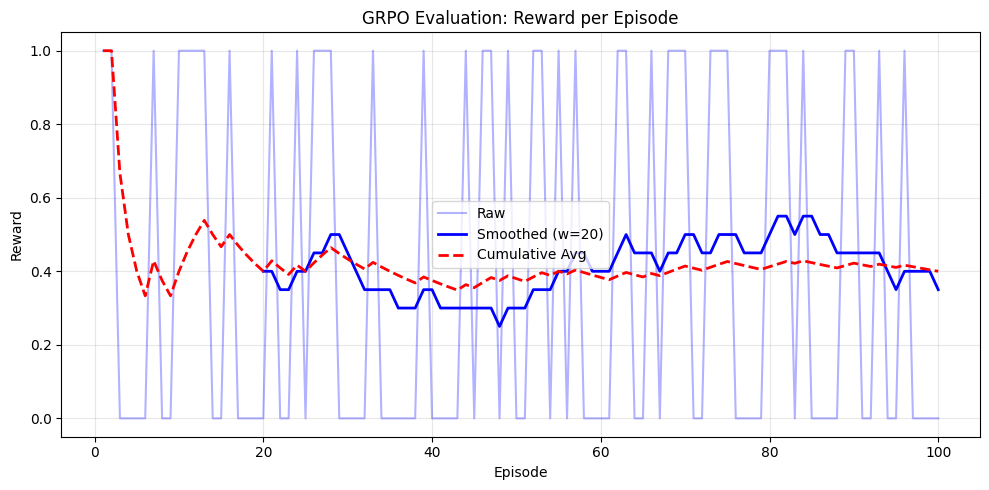

np.float64(0.4)

In [24]:
test_questions = test_questions[:100]
test_answers = test_answers[:100]

NUM_TEST_EPISODES = len(test_questions)
MAX_STEPS = 5

test_rewards = []
model.eval()

print(f"\n=== EVALUATION ({NUM_TEST_EPISODES} episodes) ===")

def greedy_generate(prompt):
    """Helper for deterministic generation during test time"""
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_SEQ_LEN,
        padding=False
    ).to(policy.device)

    with torch.no_grad():
        outputs = policy.model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_new_tokens=GENERATE_LEN,
            do_sample=False,        
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    gen_seq = outputs[0][inputs['input_ids'].shape[1]:]
    text = tokenizer.decode(gen_seq, skip_special_tokens=True)
    return text

for episode in range(NUM_TEST_EPISODES):
    state = env.reset(test_questions[episode], test_answers[episode])
    episode_reward = 0.0

    for step in range(MAX_STEPS):
        action_text = greedy_generate(state)


        action = trainer.parse_action(action_text)
        state, reward, done = env.step(action)

        episode_reward += reward

        if done:
            break

    test_rewards.append(episode_reward)

    if (episode + 1) % 10 == 0:
        avg_current = sum(test_rewards) / len(test_rewards)
        print(f"Test Episode {episode+1}/{NUM_TEST_EPISODES} | Current Avg Accuracy: {avg_current:.4f}")

final_avg = sum(test_rewards) / len(test_rewards)
print(f"\n✓ Evaluation Complete")
print(f"  Avg Reward (Accuracy): {final_avg:.4f}")
print(f"  Success Rate: {final_avg * 100:.2f}%")

plot_results(test_rewards, "GRPO Evaluation: Reward per Episode", "Episode", "Reward", 20, f"{SAVE_DIR}/test_rewards_grpo.png")